In [1]:
# load packages for analysis
import os
import ast
from cityseer.metrics import networks
from cityseer.tools import graphs, io
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from xml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm

In [2]:
cpt_taxi = gpd.read_file("ct_mobility_taxi_routes.gpkg")

In [3]:
cpt_taxi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1466 non-null   int32   
 1   ORGN        1447 non-null   object  
 2   DSTN        1447 non-null   object  
 3   SHAPE_Leng  1466 non-null   float64 
 4   geometry    1466 non-null   geometry
dtypes: float64(1), geometry(1), int32(1), object(2)
memory usage: 51.7+ KB


In [4]:
print(cpt_taxi.head())

   OBJECTID       ORGN         DSTN    SHAPE_Leng  \
0         1  BELLVILLE  DURBANVILLE  12918.668592   
1         2  BELLVILLE       NYANGA  15814.788629   
2         3  BELLVILLE  KHAYELITSHA  22221.733226   
3         4  BELLVILLE      MOWBRAY  24910.267147   
4         5   GUGULETU    CLAREMONT  15462.341551   

                                            geometry  
0  MULTILINESTRING ((2073863.968 -4016029.631, 20...  
1  MULTILINESTRING ((2073863.968 -4016029.631, 20...  
2  MULTILINESTRING ((2073863.968 -4016029.631, 20...  
3  MULTILINESTRING ((2073863.968 -4016029.631, 20...  
4  MULTILINESTRING ((2066804.532 -4027123.839, 20...  


In [5]:
if cpt_taxi.crs is None or not cpt_taxi.crs.is_projected:
        cpt_taxi = cpt_taxi.to_crs(epsg=3857)

In [8]:
cpt_taxi = cpt_taxi.dropna(subset=['ORGN', 'DSTN'])

In [9]:
cpt_taxi['ORGN'] = cpt_taxi['ORGN'].astype(str)
cpt_taxi['DSTN'] = cpt_taxi['DSTN'].astype(str)

In [10]:
for _, row in cpt_taxi.iterrows():
    origin = row['ORGN']
    destination = row['DSTN']

    # Skip if any value is missing or invalid
    if pd.isna(origin) or pd.isna(destination):
        continue

    weight = row['SHAPE_Leng']  # Distance as weight
    geometry = row['geometry']  # Edge geometry

    # Add nodes and edge
    G_ct.add_node(origin)
    G_ct.add_node(destination)
    G_ct.add_edge(origin, destination, weight=weight, geometry=geometry)

In [11]:
# Check a sample node
print(next(iter(G_ct.nodes(data=True))))

# Check a sample edge
print(next(iter(G_ct.edges(data=True))))

('BELLVILLE', {})
('BELLVILLE', 'DURBANVILLE', {'weight': 11434.070009021452, 'geometry': <MULTILINESTRING ((2073825.007 -4016149.808, 2073863.968 -4016029.631, 20737...>})


In [12]:
for _, _, data in G_ct.edges(data=True):
    print(type(data['geometry']))
    break

<class 'shapely.geometry.multilinestring.MultiLineString'>


In [16]:
from shapely.ops import linemerge, unary_union
from collections import defaultdict

# Create a new simplified graph
G_simplified = nx.DiGraph()

# Dictionary to store merged edges
merged_edges = defaultdict(lambda: {'weight': 0, 'geometry': []})

for u, v, data in G_ct.edges(data=True):
    merged_edges[(u, v)]['weight'] += data['weight']  # Summing weights
    merged_edges[(u, v)]['geometry'].append(data['geometry'])  # Store geometries

# Add merged edges to new graph
for (u, v), attr in merged_edges.items():
    geometries = attr['geometry']

    # Ensure we correctly merge geometries
    if len(geometries) == 1:
        merged_geometry = geometries[0]  # Single LineString remains unchanged
    else:
        merged_geometry = linemerge(unary_union(geometries))  # Merge multiple geometries

    G_simplified.add_edge(u, v, weight=attr['weight'], geometry=merged_geometry)

# Replace the original graph with the simplified version
G_ct = G_simplified

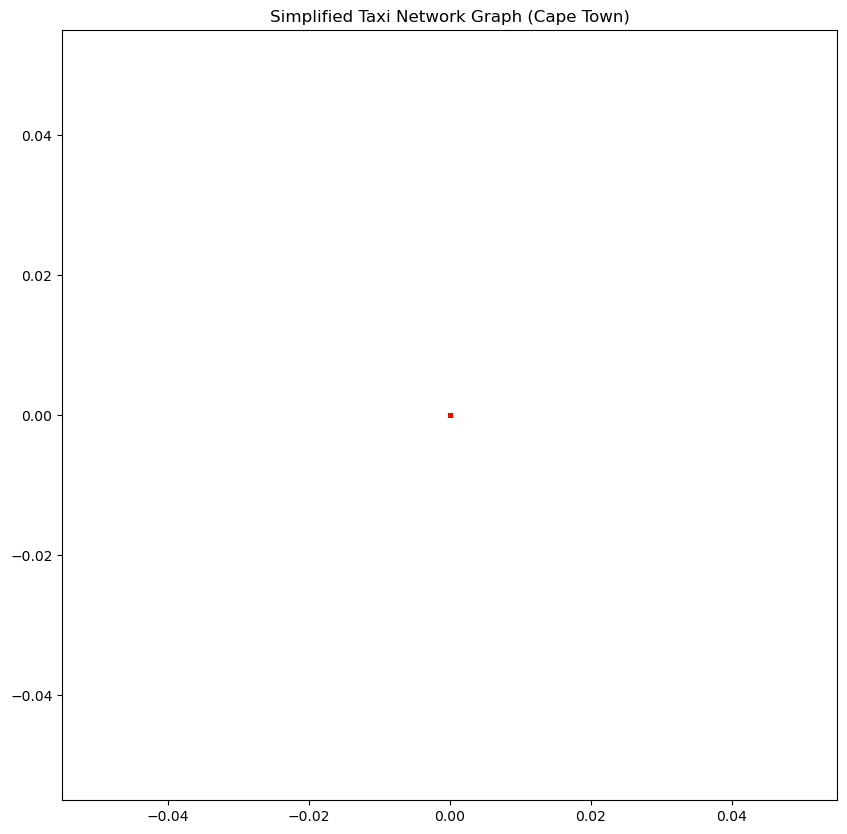

In [17]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges with their geometry
for u, v, data in G_ct.edges(data=True):
    geometry = data['geometry']
    if isinstance(geometry, LineString):
        x, y = geometry.xy
        ax.plot(x, y, color="blue", linewidth=0.5, alpha=0.7)

# Plot nodes
node_positions = {node: (G_ct.nodes[node].get('x', 0), G_ct.nodes[node].get('y', 0)) for node in G_ct.nodes}
ax.scatter(*zip(*node_positions.values()), color="red", s=5, alpha=0.7)

# Title and show plot
ax.set_title("Simplified Taxi Network Graph (Cape Town)")
plt.show()